# Procesado Espectros Raman NANOBASE

En este *Notebook* se realiza un preprocesado básico a los espectros Raman medidos con Nanobase. 

Los datos obtenidos de NanoBase corresponden a espectros en bruto a los que se les ha restado el *background*. El programa de medición no realiza ningun otro tipo de tratamiento a los datos. Por ello es necesario realizar diferentes pasos previos al análisis de los espectros:

1. Whittaker Smoother: Método de suavizado aplicado a señales con la finalidad de reducir el ruido, conservando los picos caracteristicos del material. El método funciona minimizando la suma de las diferencias al cuadrado entre cada punto de datos y su estimación suavizada, sujeto a una restricción de que la segunda diferencia de los valores suavizados es pequeña. Esta restricción tiene el efecto de penalizar las variaciones en la tasa de cambio de los valores suavizados, resultando en una señal más suave.

2. Baseline: 

Al contrario que en el preprocesado de la Sonda Raman de 532nm, no es necesario corregir el Background ya que el propio software de medida se encarga de hacerlo.


In [2]:
import numpy as np
import pandas as pd
#%matplotlib inline
import re
import os
import math
import numpy as np
import pandas as pd
import joblib
import warnings
import time
import shutil
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, Normalizer
from scipy.linalg import solveh_banded  # para hacer ALS
from scipy import sparse
from scipy.sparse.linalg import spsolve
from scipy.signal import argrelextrema
from itertools import product
from scipy.signal import savgol_filter
from functools import reduce

# Directorio en el que se encuentran guardados los datos de Raman
path_nanobase_mac = '/Users/drea/Library/CloudStorage/OneDrive-UNICAN/RamanNanoBase/CONCHAS_ARQ/CSV'
path_nanobase_windows ='D:\OneDrive - UNICAN\RamanNanoBase\CONCHAS_ARQ\CSV'
# Elegimos la ruta según el sistema operativo
path_nanobase = path_nanobase_windows
# Obtén la lista de archivos en la carpeta
files = os.listdir(path_nanobase)
# Filtrar solo los archivos CSV
csv_files = [f for f in files if f.endswith('.CSV')]

print("Número de archivos CSV: ", len(csv_files))

# Copiamos los archivos a la carpeta contenedora. Esto se realiza para poder actualizar las nuevas medidas
def copiar_archivos(origen, destino, archivos):
    # Copiar cada archivo seleccionado a la carpeta de destino si no existe
    for archivo in archivos:
        ruta_origen = os.path.join(origen, archivo)
        ruta_destino = os.path.join(destino, archivo)
        if os.path.exists(ruta_origen):
            shutil.copy2(ruta_origen, ruta_destino)
            print(f"Archivo {archivo} copiado correctamente.")
        else:
            print(f"El archivo {archivo} no existe en la carpeta de origen.")

# Ejemplo de uso
carpeta_origen = 'D:\OneDrive - UNICAN\RamanNanoBase\CONCHAS_ARQ\CSV'
carpeta_destino = "D:\OneDrive - UNICAN\Escritorio\Conchas\CSV_nanobase"

# copiar_archivos(carpeta_origen, carpeta_destino, csv_files)

Número de archivos CSV:  9


In [5]:
# Directorios de medida
csv_files = os.listdir(carpeta_destino)
print("Número de archivos CSV: ", len(csv_files))

Número de archivos CSV:  9


In [22]:
class WhittakerSmoother(object):
    def __init__(self, signal, smoothness_param, deriv_order=1):
        self.y = signal
        assert deriv_order > 0, 'deriv_order must be an int > 0'
        # Compute the fixed derivative of identity (D).
        d = np.zeros(deriv_order*2 + 1, dtype=int)
        d[deriv_order] = 1
        d = np.diff(d, n=
        deriv_order)
        n = self.y.shape[0]
        k = len(d)
        s = float(smoothness_param)
        # Here be dragons: essentially we're faking a big banded matrix D,
        # doing s * D.T.dot(D) with it, then taking the upper triangular bands.
        diag_sums = np.vstack([
            np.pad(s*np.cumsum(d[-i:]*d[:i]), ((k-i,0),), 'constant')
            for i in range(1, k+1)])
        upper_bands = np.tile(diag_sums[:,-1:], n)
        upper_bands[:,:k] = diag_sums
        for i,ds in enumerate(diag_sums):
            upper_bands[i,-i-1:] = ds[::-1][:i+1]
        self.upper_bands = upper_bands
    def smooth(self, w):
        foo = self.upper_bands.copy()
        foo[-1] += w  # last row is the diagonal
        return solveh_banded(foo, w * self.y, overwrite_ab=True, overwrite_b=True)

def als_baseline(intensities, asymmetry_param=0.0001, smoothness_param=1e4,
                 max_iters=20, conv_thresh=1e-6, verbose=False):
    """
    Applies the asymmetric least squares (ALS) method to fit the baseline.

    Parameters:
    - intensities (numpy.ndarray or pandas.Series): Numpy array or pandas Series representing the Raman intensities.
    - asymmetry_param (float): Asymmetry parameter for the fit.
    - smoothness_param (float): Smoothness parameter for the fit.
    - max_iters (int): Maximum number of iterations.
    - conv_thresh (float): Convergence threshold.
    - verbose (bool): Flag to print debugging information.

    Returns:
    - baseline (numpy.ndarray): Numpy array representing the fitted baseline.
    """
    if isinstance(intensities, pd.Series):
        intensities = intensities.values

    smoother = WhittakerSmoother(intensities, smoothness_param, deriv_order=2)
    p = asymmetry_param
    w = np.ones(intensities.shape[0])

    for i in range(max_iters):
        z = smoother.smooth(w)
        mask = intensities > z
        new_w = p * mask + (1 - p) * (~mask)
        conv = np.linalg.norm(new_w - w)
        if verbose:
            print(i + 1, conv)
        if conv < conv_thresh:
            break
        w = new_w
    else:
        None
        #print('ALS did not converge in %d iterations' % max_iters)
    return z

def subtract(df, df_background):
    df_subtracted = df.sub(df_background.iloc[0], axis=1)
    return df_subtracted

def find_baseline(df, asymmetry_param=0.0001, smoothness_param=1e4,
                 max_iters=20, conv_thresh=1e-6):
    """
    Apply baseline correction to each row in a DataFrame.
    Input:
        df: DataFrame, contains the spectral data.
    Output:
        DataFrame, with baseline corrected for each spectrum.
    """
    D0_BL = df.copy()
    for i in range(len(df)):
        # Apply ALS baseline correction to each row
        bl = als_baseline(df.iloc[i, :].values, asymmetry_param, smoothness_param,
                 max_iters, conv_thresh)
        D0_BL.iloc[i, :] = bl
    return D0_BL

def correct_baseline(data, baseline):
    """
    Corrects the baseline of the data.
    Parameters:
    - data (pandas.DataFrame or pandas.Series): DataFrame or Series containing the data.
    - baseline (pandas.DataFrame or pandas.Series): DataFrame or Series with the baselines.
    Returns:
    - corrected_data (pandas.DataFrame): DataFrame with the corrected data.
    """
    # Ensure that both data and baseline are DataFrames
    if not isinstance(data, pd.DataFrame):
         data = pd.DataFrame(data)
    if not isinstance(baseline, pd.DataFrame):
         baseline = pd.DataFrame(baseline)
    # Perform baseline correction
    
    corrected_data = data - baseline

    return corrected_data


def normalize_spectra(X_filtered):
    """
    Preprocessing of spectral data.
    Input:
        X_filtered: DataFrame, raw spectral data.
    Output:
        DataFrame, preprocessed spectral data.
    """
    X_norm_list = []
    for _, row in X_filtered.iterrows():
        # Normalize each spectrum by dividing by the sum and multiplying by a constant
        total = np.sum(row)
        X_norm_list.append(pd.DataFrame([row / total * 2000]))
    X_norm = pd.concat(X_norm_list, ignore_index=True)
    # Apply Savitzky-Golay filter for smoothing
    X_norm_flt = savgol_filter(X_norm, 21, 2)
    X_norm_flt = pd.DataFrame(X_norm_flt, columns=X_filtered.columns)
    '''# Perform baseline correction
    bl = find_baseline(X_norm_flt)
    X_norm_flt = X_norm_flt - bl'''
    # Standardize the data using StandardScaler
    scaler = StandardScaler()
    z_numpy = X_norm_flt.values
    z_numpy_scaled_rows = scaler.fit_transform(z_numpy.T).T
    X_norm_flt_stdz = pd.DataFrame(data=z_numpy_scaled_rows, columns=X_filtered.columns)
    return X_norm_flt_stdz

def SNV(input_data):
    """
    Procesado de datos: SNV (Standard Normal Variate).
    1) Media de cada channel --> axis=1 (todas las columnas).
    2) Se le resta su media a cada "channel" --> axis=0 (todas las filas).
    3) Divide cada channel por su StDev --> axis=1 (todas las columnas).
    :parameter *input_data*: matriz de datos, en formato: "channels(f) x time(c)".
    :return: matriz de datos, una vez normalizados
    """
    data_12 = input_data.sub(input_data.mean(axis=1), axis=0)
    data_snv = data_12.div(input_data.std(axis=1), axis=0)
    return data_snv

def cut_spectrum(df, min_wavelength, max_wavelength):
    """
    Cuts the spectrum to a specific range.
    Parameters:
    - df (pandas.DataFrame): DataFrame containing the spectrum.
    - min_wavelength (int): Minimum wavelength.
    - max_wavelength (int): Maximum wavelength.
    Returns:
    - df_cut (pandas.DataFrame): DataFrame containing the spectrum within the specified range.
    """
    df.columns = df.columns.astype(float) #si tus columnas deben ser números flotantes
    df_cut = df.loc[:, (df.columns >= min_wavelength) & (df.columns <= max_wavelength)]
    return df_cut

def cut_spectrum_2(df, min_wavelength, max_wavelength):
    """
    Cuts the spectrum to a specific range.
    Parameters:
    - df (pandas.DataFrame): DataFrame containing the spectrum.
    - min_wavelength (int): Minimum wavelength to include in the cut.
    - max_wavelength (int): Maximum wavelength to include in the cut.
    Returns:
    - df_cut (pandas.DataFrame): DataFrame containing the spectrum within the specified range.
    """
    # Filter out non-numeric columns before attempting to convert column names to float
    numeric_columns = [col for col in df.columns if col.replace('.', '', 1).isdigit()]
    df_numeric = df[numeric_columns]

    # Convert numeric column names to float
    df_numeric.columns = df_numeric.columns.astype(float)

    # Cut the spectrum to the specified range
    df_cut = df_numeric.loc[:, (df_numeric.columns >= min_wavelength) & (df_numeric.columns <= max_wavelength)]

    return df_cut

In [15]:
csv_files

['160424_LIT4_1000ms_n5_potenica1c_mapa_abajo.CSV',
 '170424_LIT2_1000ms_n5_potencia1c_mapa_abajo.CSV',
 '180424_LIT1_1000ms_n5_potencia1c_mapa_abajo.CSV',
 '180424_LIT3_1000ms_n5_potencia1c_mapa_abajo.CSV',
 '190424_LIT5_1000ms_n10_potencia1c_abajo.CSV',
 '230424_LIT6_1000ms_n5_potencia1c_abajo.CSV',
 '240424_LIT235.3_2000ms_n10_potencia1c_abajo.CSV',
 '250424_LIT885.1_3000ms_n8_potencia1c_abajo.CSV',
 '290424_LIT921.1_1500ms_n8_potencia1c_abajo.CSV']

In [27]:
def create_df_raw(folder_path, csv_files , cut= 'cut'):
    dataframes = []
    lista_archivos = []
    lista_muestras = []

    path = folder_path
    for csv_file in csv_files:
            csv_file_complete = os.path.join(path, csv_file)
            df_pre = pd.read_csv(csv_file_complete, engine='python', sep=',', skiprows=14, decimal='.')
            resultados = []
            archivo= csv_file

            # # Drop unwanted column
            if 'Unnamed: 1937' in df_pre.columns:
                df_pre = df_pre.drop(columns=['Unnamed: 1937'])
            df_pre.drop((['XINDEX', 'YINDEX', 'ZINDEX', 'Z']), axis=1, inplace=True)
            # Realizamos el preprocesado de los datos
            X = df_pre.columns['X']
            # df_pre_plot = df_pre.copy()
            if cut == 'cut':
                df_cut = cut_spectrum_2(df_pre, min_wavelength=179, max_wavelength=2800)
            else:
                df_cut = df_pre.copy()
            # df_find_baseline = find_baseline(df_cut)
            # df_media_corrected = correct_baseline(df_cut, df_find_baseline)


            # Podemos plotear el paso a paso para comprobar que se ha realizado correctamente
            # df_pre_plot.columns = df_pre.columns.astype(float)
            # df_pre_plot.mean(axis=0).plot()
            # df_cut.mean(axis=0).plot()
            # df_find_baseline.mean(axis=0).plot()
            # df_media_corrected.mean(axis=0).plot()
            print(archivo)

            # df = df_media_corrected.copy()

            # nombre_archivo = archivo # Nombre del archivo
            # nombre_muestra = nombre_archivo.split("_")[3] # Nombre de la muestra
            # fecha_medida = nombre_archivo.split("_")[0].split("-")[0]  # Fecha de la medida
            # hora_medida = nombre_archivo.split("_")[0].split("-")[1]    # Hora de la medida
            # tipo_laser =   "Nanobase"
            # tipo = 'raw'
            # df.index = pd.MultiIndex.from_tuples([( tipo_laser, nombre_muestra, tipo,
            #                                             fecha_medida,hora_medida, nombre_archivo, X, Y, ) for X, Y in df.index],
            #                                       names=[ "Instrumento","Muestra","Tipo",  "Fecha","Hora", "Archivo","X", "Y"])

            # Guardamos el nombre de los archivos y de las muestras en listas
            # lista_archivos.append(nombre_archivo)
            # lista_muestras.append(nombre_muestra)
            # # Agrega el DataFrame a la lista
            dataframes.append(df_cut)

    # Concatena todos los DataFrames en uno solo
    data = pd.concat(dataframes)
    return data, X

data, coordenadas = create_df_raw(carpeta_destino, ['160424_LIT4_1000ms_n5_potenica1c_mapa_abajo.CSV'], cut='cut')
data

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [25]:
coordenadas

Index(['Y', '-77.043', '-74.805', '-72.569', '-70.332', '-68.093', '-65.856',
       '-63.622', '-61.383', '-59.153',
       ...
       '3304.067', '3305.232', '3306.397', '3307.567', '3308.734', '3309.900',
       '3311.064', '3312.227', '3313.389', '3314.551'],
      dtype='object', length=1932)

In [21]:
data

,X,Y,-77.043,-74.805,-72.569,-70.332,-68.093,-65.856,-63.622,-61.383,...,3304.067,3305.232,3306.397,3307.567,3308.734,3309.900,3311.064,3312.227,3313.389,3314.551
0,-187.014249,-51.936528,316.4,338.6,326.8,320.0,318.4,320.4,349.0,304.8,...,4474.6,4404.8,4346.4,4612.4,4417.6,4518.0,4493.4,4438.8,4383.6,4475.2
1,-183.514249,-51.936528,312.8,299.8,312.8,321.6,328.4,324.0,331.8,336.4,...,4322.4,4244.4,4257.8,4252.6,4138.2,4296.6,4187.4,4315.8,4197.0,4162.8
2,-180.014249,-51.936528,328.0,339.4,319.2,336.0,321.6,336.8,318.2,302.4,...,5390.4,5342.6,5404.0,5395.6,5353.6,5278.6,5324.4,5412.8,5258.0,5287.8
3,-176.514249,-51.936528,326.4,290.6,310.0,309.6,320.4,329.6,315.8,314.8,...,3448.4,3580.8,3538.8,3577.6,3466.8,3647.6,3439.2,3559.0,3518.6,3496.0
4,-173.014249,-51.936528,306.4,313.4,340.4,319.6,325.2,353.2,324.6,314.8,...,4960.2,4862.8,4820.2,4977.6,4862.6,4931.0,4844.8,4894.2,4775.6,4816.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4489,169.985751,50.563472,319.6,313.0,354.4,318.4,326.0,326.4,331.0,337.2,...,3613.8,3693.0,3751.2,3793.4,3620.0,3666.0,3663.8,3665.2,3662.8,3593.2
4490,173.485751,50.563472,334.8,333.8,336.4,299.6,320.4,320.8,316.2,341.2,...,3157.6,3116.4,3076.4,3080.6,3110.0,3130.6,3135.0,3071.6,3130.8,2978.4
4491,176.985751,50.563472,310.8,315.0,334.4,352.4,308.0,324.4,333.4,311.2,...,3411.8,3500.4,3447.0,3475.6,3441.2,3543.6,3544.6,3460.8,3442.4,3428.6
4492,180.485751,50.563472,336.8,294.6,334.0,308.8,304.4,325.2,309.4,320.0,...,4396.2,4269.8,4347.6,4419.6,4302.4,4475.6,4374.2,4383.8,4370.6,4268.2


## Funciones

In [18]:
class WhittakerSmoother(object):
    def __init__(self, signal, smoothness_param, deriv_order=1):
        self.y = signal
        assert deriv_order > 0, 'deriv_order must be an int > 0'
        # Compute the fixed derivative of identity (D).
        d = np.zeros(deriv_order*2 + 1, dtype=int)
        # d[deriv_order] = 1
        d = np.diff(d, n=
        deriv_order)
        n = self.y.shape[0]
        k = len(d)
        s = float(smoothness_param)
        # Here be dragons: essentially we're faking a big banded matrix D,
        # doing s * D.T.dot(D) with it, then taking the upper triangular bands.
        diag_sums = np.vstack([
            np.pad(s*np.cumsum(d[-i:]*d[:i]), ((k-i,0),), 'constant')
            for i in range(1, k+1)])
        upper_bands = np.tile(diag_sums[:,-1:], n)
        upper_bands[:,:k] = diag_sums
        for i,ds in enumerate(diag_sums):
            upper_bands[i,-i-1:] = ds[::-1][:i+1]
        self.upper_bands = upper_bands
    def smooth(self, w):
        foo = self.upper_bands.copy()
        foo[-1] += w  # last row is the diagonal
        return solveh_banded(foo, w * self.y, overwrite_ab=True, overwrite_b=True)

def als_baseline(intensities, asymmetry_param=0.0001, smoothness_param=1e4,
                 max_iters=20, conv_thresh=1e-6, verbose=False):
    """
    Applies the asymmetric least squares (ALS) method to fit the baseline.

    Parameters:
    - intensities (numpy.ndarray or pandas.Series): Numpy array or pandas Series representing the Raman intensities.
    - asymmetry_param (float): Asymmetry parameter for the fit.
    - smoothness_param (float): Smoothness parameter for the fit.
    - max_iters (int): Maximum number of iterations.
    - conv_thresh (float): Convergence threshold.
    - verbose (bool): Flag to print debugging information.

    Returns:
    - baseline (numpy.ndarray): Numpy array representing the fitted baseline.
    """
    if isinstance(intensities, pd.Series):
        intensities = intensities.values

    smoother = WhittakerSmoother(intensities, smoothness_param, deriv_order=2)
    p = asymmetry_param
    w = np.ones(intensities.shape[0])

    for i in range(max_iters):
        z = smoother.smooth(w)
        mask = intensities > z
        new_w = p * mask + (1 - p) * (~mask)
        conv = np.linalg.norm(new_w - w)

        if verbose:
            print(i + 1, conv)

        if conv < conv_thresh:
            break

        w = new_w
    else:
        # print('ALS did not converge in %d iterations' % max_iters)
        pass

    return z



def find_baseline(df):
    """
    Apply baseline correction to each row in a DataFrame.
    Input:
        df: DataFrame, contains the spectral data.
    Output:
        DataFrame, with baseline corrected for each spectrum.
    """
    D0_BL = df.copy()
    for i in range(len(df)):
        # Apply ALS baseline correction to each row
        bl = als_baseline(df.iloc[i, :].values)
        D0_BL.iloc[i, :] = bl
    return D0_BL

def remove_background(df):
    D0_BG = df.copy()

    return D0_BG

def correct_baseline(data, baseline):
    """
    Corrects the baseline of the data.
    Parameters:
    - data (pandas.DataFrame or pandas.Series): DataFrame or Series containing the data.
    - baseline (pandas.DataFrame or pandas.Series): DataFrame or Series with the baselines.
    Returns:
    - corrected_data (pandas.DataFrame): DataFrame with the corrected data.
    """
    # Ensure that both data and baseline are DataFrames
    if not isinstance(data, pd.DataFrame):
        data = pd.DataFrame(data)

    if not isinstance(baseline, pd.DataFrame):
        baseline = pd.DataFrame(baseline)

    # Perform baseline correction
    corrected_data = data.values - baseline.values

    # Convert the result back to a DataFrame while maintaining the same column names
    corrected_data = pd.DataFrame(corrected_data, columns=data.columns).copy()

    return corrected_data


def normalize_spectra(X_filtered):
    """
    Preprocessing of spectral data.
    Input:
        X_filtered: DataFrame, raw spectral data.
    Output:
        DataFrame, preprocessed spectral data.
    """
    X_norm_list = []
    for _, row in X_filtered.iterrows():
        # Normalize each spectrum by dividing by the sum and multiplying by a constant
        total = np.sum(row)
        X_norm_list.append(pd.DataFrame([row / total * 2000]))

    X_norm = pd.concat(X_norm_list, ignore_index=True)

    # Apply Savitzky-Golay filter for smoothing
    X_norm_flt = savgol_filter(X_norm, 21, 2)
    X_norm_flt = pd.DataFrame(X_norm_flt, columns=X_filtered.columns)

    '''# Perform baseline correction
    bl = find_baseline(X_norm_flt)
    X_norm_flt = X_norm_flt - bl'''

    # Standardize the data using StandardScaler
    scaler = StandardScaler()
    z_numpy = X_norm_flt.values
    z_numpy_scaled_rows = scaler.fit_transform(z_numpy.T).T
    X_norm_flt_stdz = pd.DataFrame(data=z_numpy_scaled_rows, columns=X_filtered.columns)

    return X_norm_flt_stdz



def procesarRamanNanobase(file):
    
    df = pd.read_csv(file, engine='python', sep=',', skiprows=14, decimal='.')
    resultados = []
    archivo= file

    # # Drop unwanted column
    if 'Unnamed: 1937' in df.columns:
            df = df.drop(columns=['Unnamed: 1937'])

    # Store coordinates
    coordenadas = df.iloc[:, 0:2].T
        
    # Select only ramanshift columns
    df2 = df.iloc[:, 7:]

    # Create a DataFrame for Raman shift values
    ramanshitfs = pd.DataFrame(df2.columns.astype(float), columns=['Raman shift'])

    # Select Raman spectra data within the desired range
    D = df2.loc[:, (df2.columns.astype(float) >= 500) & (df2.columns.astype(float) <=2000)]

    # Filter Raman shift values within the desired range
    ramanshitfs = ramanshitfs.loc[(ramanshitfs['Raman shift'] >= 500) & (ramanshitfs['Raman shift'] <= 2000)]


    #Filtrado de espectros saturados
    # guardado del número total de filas
    total_rows = len(D)
    # Descartar las filas donde cualquier valor supera 65000
    D = D[~(D > 65000).any(axis=1)]

    # Guardar el número de filas después de descartar
    remaining_rows = len(D)
    # Calcular e imprimir el número de filas descartadas
    discarded_rows = total_rows - remaining_rows
    print(f'{archivo}: se descartaron {discarded_rows} espectros saturados de un total de {total_rows} espectros.')
    
    # Find baseline of Raman spectra data
    D_BL = find_baseline(D)
    # Correct baseline of Raman spectra data
    D_BC =correct_baseline(D, D_BL)
    # Normalize Raman spectra data
    D_PP = normalize_spectra(D_BC)

    df_final = pd.concat([coordenadas.T, D_PP], axis=1)
    df_final.set_index(['X', 'Y'], inplace=True)

    tipo_laser = "Nanobase"
    nombre_archivo = archivo.split('\\')[-1].split('.')[0]
    nombre_muestra = nombre_archivo.split('_')[1]
    fecha_medida = nombre_archivo.split('_')[0]
    hora_medida = nombre_archivo.split("_")[0].split("-")[1]
    tipo = 'raw'
    df_final.index = pd.MultiIndex.from_tuples([( tipo_laser, nombre_muestra, tipo,
                                                        fecha_medida,hora_medida, nombre_archivo, X, Y, ) for X, Y in df_final.index],
                                                  names=[ "Instrumento","Muestra","Tipo",  "Fecha","Hora", "Archivo","X", "Y"])
    
    # Append processed data to the results list
    resultados.append((archivo, coordenadas, D, D_BL, D_PP, ramanshitfs))

    return df_final, resultados


def procesarRamanSonda(file):
    resultados_sonda =[]
    archivo = file

    df_sonda = pd.read_csv(file)
    # Store coordinates
    df_sonda_reset = df_sonda.reset_index()
    coordenadas_sonda = df_sonda_reset.iloc[:, :2]
    coordenadas_sonda.columns = ['X', 'Y']
    coordenadas_sonda = coordenadas_sonda.T
            
    df2_sonda = df_sonda.iloc[:, 3:]

    # Create a DataFrame for Raman shift values
    ramanshitfs_sonda = pd.DataFrame(df2_sonda.columns.astype(float), columns=['Raman shift'])
    # Select Raman spectra data within the desired range
    D_sonda = df2_sonda.loc[:, (df2_sonda.columns.astype(float) >= 500.0) & (df2_sonda.columns.astype(float) <= 2000.0)]
    # Filter Raman shift values within the desired range
    ramanshitfs_sonda = ramanshitfs_sonda.loc[(ramanshitfs_sonda['Raman shift'] >= 500) & (ramanshitfs_sonda['Raman shift'] <= 2000)]
    #Filtrado de espectros saturados
    total_rows_sonda = len(D_sonda)
    # Descartar las filas donde cualquier valor supera 65000
    D_sonda = D_sonda[~(D_sonda > 65000).any(axis=1)]
    # Guardar el número de filas después de descartar
    remaining_rows_sonda = len(D_sonda)
    # Calcular e imprimir el número de filas descartadas
    discarded_rows_sonda = total_rows_sonda - remaining_rows_sonda

    archivo_sonda ='Sonda'
    print(f'{archivo_sonda}: se descartaron {discarded_rows_sonda} espectros saturados de un total de {total_rows_sonda} espectros.')

        # Removing Background
    D_BG_sonda = remove_background(D_sonda)
    # Find baseline of Raman spectra data
    D_BL_sonda = find_baseline(D_BG_sonda)
    # Correct baseline of Raman spectra data
    D_BC_sonda = correct_baseline(D_sonda, D_BL_sonda)
    # Normalize Raman spectra data
    D_PP_sonda = normalize_spectra(D_BC_sonda)

    
    df_sonda_final = pd.concat([coordenadas_sonda.T, D_PP_sonda], axis=1)
    df_sonda_final.set_index(['X', 'Y'], inplace=True)

    resultados_sonda.append((archivo, coordenadas_sonda, D_sonda, D_BL_sonda, D_PP_sonda, ramanshitfs_sonda))

    nombre_archivo = archivo.split("\\")[-2] # Nombre del archivo
    nombre_muestra = nombre_archivo.split("_")[3] # Nombre de la muestra
    fecha_medida = nombre_archivo.split("_")[0].split("-")[0]  # Fecha de la medida
    hora_medida = nombre_archivo.split("_")[0].split("-")[1]    # Hora de la medida
    tipo_laser =   f"Sonda {nombre_archivo.split('_')[2]}"
    tipo = 'raw'
    df_sonda_final.index = pd.MultiIndex.from_tuples([( tipo_laser, nombre_muestra, tipo,
                                                        fecha_medida,hora_medida, nombre_archivo, X, Y, ) for X, Y in df_sonda_final.index],
                                                  names=[ "Instrumento","Muestra","Tipo",  "Fecha","Hora", "Archivo","X", "Y"])
    return df_sonda_final, resultados_sonda

In [85]:
class WhittakerSmoother(object):
  def __init__(self, signal, smoothness_param, deriv_order=1):
    self.y = signal
    assert deriv_order > 0, 'deriv_order must be an int > 0'
    # Compute the fixed derivative of identity (D).
    d = np.zeros(deriv_order*2 + 1, dtype=int)
    d[deriv_order] = 1
    d = np.diff(d, n=
    deriv_order)
    n = self.y.shape[0]
    k = len(d)
    s = float(smoothness_param)
    # Here be dragons: essentially we're faking a big banded matrix D,
    # doing s * D.T.dot(D) with it, then taking the upper triangular bands.
    diag_sums = np.vstack([
        np.pad(s*np.cumsum(d[-i:]*d[:i]), ((k-i,0),), 'constant')
        for i in range(1, k+1)])
    upper_bands = np.tile(diag_sums[:,-1:], n)
    upper_bands[:,:k] = diag_sums
    for i,ds in enumerate(diag_sums):
      upper_bands[i,-i-1:] = ds[::-1][:i+1]
    self.upper_bands = upper_bands
  def smooth(self, w):
    foo = self.upper_bands.copy()
    foo[-1] += w  # last row is the diagonal
    return solveh_banded(foo, w * self.y, overwrite_ab=True, overwrite_b=True)


def als_baseline(intensities, asymmetry_param=0.0001, smoothness_param=1e4,
                 max_iters=20, conv_thresh=1e-6, verbose=False):
    """
    Applies the asymmetric least squares (ALS) method to fit the baseline.

    Parameters:
    - intensities (numpy.ndarray or pandas.Series): Numpy array or pandas Series representing the Raman intensities.
    - asymmetry_param (float): Asymmetry parameter for the fit.
    - smoothness_param (float): Smoothness parameter for the fit.
    - max_iters (int): Maximum number of iterations.
    - conv_thresh (float): Convergence threshold.
    - verbose (bool): Flag to print debugging information.

    Returns:
    - baseline (numpy.ndarray): Numpy array representing the fitted baseline.
    """
    if isinstance(intensities, pd.Series):
        intensities = intensities.values

    smoother = WhittakerSmoother(intensities, smoothness_param, deriv_order=2)
    p = asymmetry_param
    w = np.ones(intensities.shape[0])

    for i in range(max_iters):
        z = smoother.smooth(w)
        mask = intensities > z
        new_w = p * mask + (1 - p) * (~mask)
        conv = np.linalg.norm(new_w - w)

        if verbose:
            print(i + 1, conv)

        if conv < conv_thresh:
            break

        w = new_w
    else:
        print('ALS did not converge in %d iterations' % max_iters)

    return z

def find_baseline(df):
    """
    Apply baseline correction to each row in a DataFrame.
    Input:
        df: DataFrame, contains the spectral data.
    Output:
        DataFrame, with baseline corrected for each spectrum.
    """
    D0_BL = df.copy()
    for i in range(len(df)):
        # Apply ALS baseline correction to each row
        bl = als_baseline(df.iloc[i, :].values)
        D0_BL.iloc[i, :] = bl
    return D0_BL


def correct_baseline(data, baseline):
    """
    Corrects the baseline of the data.
    Parameters:
    - data (pandas.DataFrame or pandas.Series): DataFrame or Series containing the data.
    - baseline (pandas.DataFrame or pandas.Series): DataFrame or Series with the baselines.
    Returns:
    - corrected_data (pandas.DataFrame): DataFrame with the corrected data.
    """
    # Ensure that both data and baseline are DataFrames
    if not isinstance(data, pd.DataFrame):
        data = pd.DataFrame(data)

    if not isinstance(baseline, pd.DataFrame):
        baseline = pd.DataFrame(baseline)

    # Perform baseline correction
    corrected_data = data.values - baseline.values

    # Convert the result back to a DataFrame while maintaining the same column names
    corrected_data = pd.DataFrame(corrected_data, columns=data.columns).copy()

    return corrected_data


def normalize_spectra(X_filtered):
    """
    Preprocessing of spectral data.
    Input:
        X_filtered: DataFrame, raw spectral data.
    Output:
        DataFrame, preprocessed spectral data.
    """
    X_norm_list = []
    for _, row in X_filtered.iterrows():
        # Normalize each spectrum by dividing by the sum and multiplying by a constant
        total = np.sum(row)
        X_norm_list.append(pd.DataFrame([row / total * 2000]))

    X_norm = pd.concat(X_norm_list, ignore_index=True)

    # Apply Savitzky-Golay filter for smoothing
    X_norm_flt = savgol_filter(X_norm, 21, 2)
    X_norm_flt = pd.DataFrame(X_norm_flt, columns=X_filtered.columns)

    '''# Perform baseline correction
    bl = find_baseline(X_norm_flt)
    X_norm_flt = X_norm_flt - bl'''

    # Standardize the data using StandardScaler
    scaler = StandardScaler()
    z_numpy = X_norm_flt.values
    z_numpy_scaled_rows = scaler.fit_transform(z_numpy.T).T
    X_norm_flt_stdz = pd.DataFrame(data=z_numpy_scaled_rows, columns=X_filtered.columns)

    return X_norm_flt_stdz


def procesarRaman_carpeta(archivos_csv):
    """
    Process Raman spectra data from a folder.

    Args:
        ruta (str): The path to the folder containing the Raman spectra data files.

    Returns:
        list: A list of tuples containing the processed data for each file. Each tuple contains:
            - The file name
            - The coordinates
            - The raw Raman spectra data
            - The baseline-corrected Raman spectra data
            - The preprocessed Raman spectra data
            - The Raman shift values
    """

    resultados = []

    for archivo in archivos_csv:
        # Read the CSV file
        df = pd.read_csv(os.path.join('D:\OneDrive - UNICAN\Escritorio\Conchas\CSV_nanobase', archivo), engine='python', sep=',', skiprows=14, decimal='.')

        # Drop unwanted column
        if 'Unnamed: 1937' in df.columns:
            df = df.drop(columns=['Unnamed: 1937'])

        # Store coordinates
        coordenadas = df.iloc[:, 0:2].T
        
        # Select only ramanshift columns
        df2 = df.iloc[:, 7:]

        # Create a DataFrame for Raman shift values
        ramanshitfs = pd.DataFrame(df2.columns.astype(float), columns=['Raman shift'])

        # Select Raman spectra data within the desired range
        D = df2.loc[:, (df2.columns.astype(float) >= 600.0) & (df2.columns.astype(float) <= 2800.0)]

        # Filter Raman shift values within the desired range
        ramanshitfs = ramanshitfs.loc[(ramanshitfs['Raman shift'] >= 600) & (ramanshitfs['Raman shift'] <= 2800)]


        #Filtrado de espectros saturados
        # guardado del número total de filas
        total_rows = len(D)
        # Descartar las filas donde cualquier valor supera 65000
        D = D[~(D > 65000).any(axis=1)]

        # Guardar el número de filas después de descartar
        remaining_rows = len(D)
        # Calcular e imprimir el número de filas descartadas
        discarded_rows = total_rows - remaining_rows
        print(f'{archivo}: se descartaron {discarded_rows} espectros saturados de un total de {total_rows} espectros.')
    

        # Find baseline of Raman spectra data
        D_BL = find_baseline(D)

        # Correct baseline of Raman spectra data
        D_BC = correct_baseline(D, D_BL)

        # Normalize Raman spectra data
        # D_PP = normalize_spectra(D_BC)
        D_PP = D_BC

        # Append processed data to the results list
        resultados.append((archivo, coordenadas, D, D_BC, ramanshitfs))

    return resultados

In [99]:
archivos = os.listdir('D:\OneDrive - UNICAN\Escritorio\Conchas\CSV_nanobase')
archivos

['160424_LIT4_1000ms_n5_potenica1c_mapa_abajo.CSV',
 '170424_LIT2_1000ms_n5_potencia1c_mapa_abajo.CSV',
 '180424_LIT1_1000ms_n5_potencia1c_mapa_abajo.CSV',
 '180424_LIT3_1000ms_n5_potencia1c_mapa_abajo.CSV',
 '190424_LIT5_1000ms_n10_potencia1c_abajo.CSV',
 '230424_LIT6_1000ms_n5_potencia1c_abajo.CSV',
 '240424_LIT235.3_2000ms_n10_potencia1c_abajo.CSV',
 '250424_LIT885.1_3000ms_n8_potencia1c_abajo.CSV',
 '290424_LIT921.1_1500ms_n8_potencia1c_abajo.CSV']

In [203]:
LIT235_3 = procesarRaman_carpeta(['240424_LIT235.3_2000ms_n10_potencia1c_abajo.CSV'])
LIT885_1 = procesarRaman_carpeta(['250424_LIT885.1_3000ms_n8_potencia1c_abajo.CSV'])
LIT3 = procesarRaman_carpeta(['180424_LIT3_1000ms_n5_potencia1c_mapa_abajo.CSV'])
LIT5 = procesarRaman_carpeta(['190424_LIT5_1000ms_n10_potencia1c_abajo.CSV'])
LIT6 = procesarRaman_carpeta(['230424_LIT6_1000ms_n5_potencia1c_abajo.CSV'])
LIT4 = procesarRaman_carpeta(['160424_LIT4_1000ms_n5_potenica1c_mapa_abajo.CSV'])
LIT2 = procesarRaman_carpeta(['170424_LIT2_1000ms_n5_potencia1c_mapa_abajo.CSV'])
LIT1 = procesarRaman_carpeta(['180424_LIT1_1000ms_n5_potencia1c_mapa_abajo.CSV'])

240424_LIT235.3_2000ms_n10_potencia1c_abajo.CSV: se descartaron 0 espectros saturados de un total de 1624 espectros.
250424_LIT885.1_3000ms_n8_potencia1c_abajo.CSV: se descartaron 919 espectros saturados de un total de 1092 espectros.
180424_LIT3_1000ms_n5_potencia1c_mapa_abajo.CSV: se descartaron 0 espectros saturados de un total de 4494 espectros.
190424_LIT5_1000ms_n10_potencia1c_abajo.CSV: se descartaron 1 espectros saturados de un total de 4482 espectros.
230424_LIT6_1000ms_n5_potencia1c_abajo.CSV: se descartaron 0 espectros saturados de un total de 4482 espectros.
160424_LIT4_1000ms_n5_potenica1c_mapa_abajo.CSV: se descartaron 127 espectros saturados de un total de 4494 espectros.
170424_LIT2_1000ms_n5_potencia1c_mapa_abajo.CSV: se descartaron 0 espectros saturados de un total de 4494 espectros.
180424_LIT1_1000ms_n5_potencia1c_mapa_abajo.CSV: se descartaron 30 espectros saturados de un total de 4482 espectros.


In [204]:
ramanshitf= [LIT235_3[0][4], LIT885_1[0][4], LIT3[0][4], LIT5[0][4], LIT6[0][4], LIT4[0][4], LIT2[0][4], LIT1[0][4]]


conjuntos = [set(lst) for lst in ramanshitf]

# Crear un diccionario para almacenar los resultados de las comparaciones
resultados = {}

# Comparar cada conjunto con los demás
for i, conjunto1 in enumerate(conjuntos):
    resultados[f'lista_{i+1}'] = []
    for j, conjunto2 in enumerate(conjuntos):
        if i != j and conjunto1 == conjunto2:
            resultados[f'lista_{i+1}'].append(f'lista_{j+1}')

# Imprimir los resultados
for lista, iguales in resultados.items():
    if iguales:
        print(f'{lista} es igual a: {", ".join(iguales)}')
    else:
        print(f'{lista} no tiene listas iguales.')

lista_1 es igual a: lista_2, lista_3, lista_4, lista_5, lista_6, lista_7, lista_8
lista_2 es igual a: lista_1, lista_3, lista_4, lista_5, lista_6, lista_7, lista_8
lista_3 es igual a: lista_1, lista_2, lista_4, lista_5, lista_6, lista_7, lista_8
lista_4 es igual a: lista_1, lista_2, lista_3, lista_5, lista_6, lista_7, lista_8
lista_5 es igual a: lista_1, lista_2, lista_3, lista_4, lista_6, lista_7, lista_8
lista_6 es igual a: lista_1, lista_2, lista_3, lista_4, lista_5, lista_7, lista_8
lista_7 es igual a: lista_1, lista_2, lista_3, lista_4, lista_5, lista_6, lista_8
lista_8 es igual a: lista_1, lista_2, lista_3, lista_4, lista_5, lista_6, lista_7


In [205]:
LIT235_3[0][3]

,601.910,604.034,606.159,608.281,610.400,612.523,614.646,616.765,618.886,621.008,...,2786.532,2787.967,2789.398,2790.836,2792.267,2793.696,2795.126,2796.558,2797.985,2799.417
0,89.499219,-9.544580,198.511621,85.168774,-0.272169,80.189742,79.055487,205.226040,8.202380,257.985480,...,393.871281,245.091994,458.515962,119.742647,184.771509,177.902003,271.633587,-5.534288,166.997831,259.629947
1,85.389525,143.088004,6.886481,37.584956,-9.516576,129.081885,177.181286,156.682576,96.986699,195.094601,...,354.400880,312.408829,106.918881,229.730509,279.643189,-5.343607,177.169590,74.082783,91.595976,21.909168
2,-8.732671,114.112964,200.959473,111.607727,200.458596,17.712949,173.571654,155.835576,135.505581,218.682532,...,309.231937,371.845323,373.258656,357.071950,169.585219,173.398469,117.111709,209.124942,92.838173,73.651403
3,3.219866,53.198804,51.077743,3.856681,119.735617,57.814551,77.193479,111.972399,68.551308,156.330201,...,306.193060,657.034636,465.979577,496.227332,325.477345,426.629055,315.781899,-5.764694,276.388707,209.242106
4,205.953411,238.107032,175.060650,145.814262,86.567861,111.721440,72.574990,70.328502,144.781965,122.135367,...,201.389805,142.229413,245.368960,150.808460,351.747926,190.087371,281.326801,65.466224,117.105642,155.445059
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1619,136.908536,144.290809,157.473081,58.255348,20.437607,49.119852,-3.397921,111.484281,161.066793,70.749948,...,270.099166,100.094577,243.289949,307.785295,296.180624,46.175943,104.271256,133.266565,46.061873,34.157181
1620,55.869767,54.523461,70.977155,56.530847,9.384536,44.838219,207.191893,85.845556,82.199203,139.052828,...,148.917387,255.484456,215.353064,170.122907,196.493677,143.965064,-3.163243,66.008443,247.080126,39.051809
1621,127.163899,142.465521,135.467141,220.868757,76.470365,52.371959,117.273532,-3.924924,65.076582,67.478435,...,99.958453,195.908497,232.558510,120.708501,127.558476,40.808439,107.458395,58.608347,144.658297,21.908247
1622,37.619554,-0.596822,104.086802,79.770485,-2.145715,31.338259,42.422681,75.807821,85.693950,14.881339,...,315.038340,170.046250,123.056220,256.167911,78.880981,178.395086,47.509883,-3.474976,27.840165,58.555305


In [ ]:
nuevos_nombres_header = LIT235_3[0][4]['Raman shift']
data_2 = LIT235_3[0][3]
data_3.columns = nuevos_nombres_header

In [216]:

nuevos_nombres_header_235 = LIT235_3[0][4]['Raman shift']
data_235 = LIT235_3[0][3]
data_235.columns = nuevos_nombres_header_235

nuevos_nombres_header_885 = LIT885_1[0][4]['Raman shift']
data_885 = LIT885_1[0][3]
data_885.columns = nuevos_nombres_header_885

nuevos_nombres_header_3 = LIT3[0][4]['Raman shift']
data_3 = LIT3[0][3]
data_3.columns = nuevos_nombres_header_3

nuevos_nombres_header_5 = LIT5[0][4]['Raman shift']
data_5 = LIT5[0][3]
data_5.columns = nuevos_nombres_header_5

nuevos_nombres_header_6 = LIT6[0][4]['Raman shift']
data_6 = LIT6[0][3]
data_6.columns = nuevos_nombres_header_6

nuevos_nombres_header_4 = LIT4[0][4]['Raman shift']
data_4 = LIT4[0][3]
data_4.columns = nuevos_nombres_header_4

nuevos_nombres_header_2 = LIT2[0][4]['Raman shift']
data_2 = LIT2[0][3]
data_2.columns = nuevos_nombres_header_2

nuevos_nombres_header_1 = LIT1[0][4]['Raman shift']
data_1 = LIT1[0][3]
data_1.columns = nuevos_nombres_header_1






In [218]:
data_1['Muestra']= 'LIT1'
data_2['Muestra']= 'LIT2'
data_3['Muestra']= 'LIT3'
data_4['Muestra']= 'LIT4'
data_5['Muestra']= 'LIT5'
data_6['Muestra']= 'LIT6'
data_235['Muestra']= 'LIT235.3'
data_885['Muestra']= 'LIT885.1'


In [245]:
data = pd.concat([data_1,data_2,data_3,data_5, data_6])
data_Arq = pd.concat([data_235, data_885])
data.set_index('Muestra', inplace=True)
data_Arq.set_index('Muestra', inplace=True)
data.columns = data.columns.astype(float)
data_Arq.columns = data_Arq.columns.astype(float)
data

Raman shift,600.941,603.068,605.189,607.312,609.436,611.558,613.676,615.798,617.920,620.038,...,2786.201,2787.638,2789.071,2790.505,2791.936,2793.373,2794.804,2796.233,2797.662,2799.094
Muestra,,,,,,,,,,,,,,,,,,,,,
LIT1,283.927991,279.269826,228.811658,203.553481,216.095288,228.837069,230.978811,240.720500,262.662120,214.803651,...,-1.770768,36.473130,126.717001,32.960850,90.004682,43.648504,133.492317,22.936126,115.579932,64.223738
LIT1,224.217727,310.336417,290.055104,306.373784,256.092448,288.611086,282.129682,252.448220,273.566681,230.485042,...,142.023878,147.505456,130.189955,186.676892,102.765781,190.656134,164.747464,-4.960721,147.931088,247.622894
LIT1,216.088181,89.074545,177.260908,169.047265,89.833611,68.419942,138.806248,44.992523,114.378755,149.364937,...,174.652085,175.840264,182.628372,142.616423,132.004432,271.792411,142.580369,178.368314,357.756254,111.544193
LIT1,244.096738,291.113798,289.530855,288.347905,266.164938,236.181945,219.398910,237.215819,195.432651,207.049388,...,94.823163,110.200929,-6.220724,130.757592,65.335883,30.914156,171.492417,103.670671,203.848922,60.227172
LIT1,478.689502,441.236681,359.983856,418.531016,316.278149,396.825239,259.172265,347.519203,332.866026,304.812704,...,213.250363,125.149351,130.448287,118.147183,20.646047,72.344889,287.043715,235.342534,128.641350,85.340166
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LIT6,-0.812840,94.545659,68.704239,2.462982,78.621965,71.981269,157.140973,23.301155,51.661891,50.623258,...,99.473390,159.689547,136.506507,76.524139,69.342311,170.760888,174.579736,-1.401281,173.617699,54.236679
LIT6,99.344097,49.903559,89.863020,107.222478,40.581932,122.541377,27.500810,142.060225,94.219618,146.378982,...,65.706670,70.735558,72.964422,95.993265,58.622094,46.250912,55.479723,112.508530,98.337335,35.966140
LIT6,98.057732,76.479076,77.900419,64.321759,50.743094,71.964420,79.385735,51.007033,69.828309,121.049558,...,46.837551,76.460691,141.483819,52.706939,69.530053,10.153162,33.776269,33.399374,19.222478,30.645582


In [249]:
data_235.set_index('Muestra', inplace=True)
data_885.set_index('Muestra', inplace=True)

KeyError: "None of ['Muestra'] are in the columns"

In [253]:
nuevos_nombres_header_2

309      600.941
310      603.068
311      605.189
312      607.312
313      609.436
          ...   
1527    2793.373
1528    2794.804
1529    2796.233
1530    2797.662
1531    2799.094
Name: Raman shift, Length: 1223, dtype: float64

In [255]:

data_235_copy = data_235.copy()
data_235

Raman shift,601.910,604.034,606.159,608.281,610.400,612.523,614.646,616.765,618.886,621.008,...,2786.532,2787.967,2789.398,2790.836,2792.267,2793.696,2795.126,2796.558,2797.985,2799.417
Muestra,,,,,,,,,,,,,,,,,,,,,
LIT235.3,89.499219,-9.544580,198.511621,85.168774,-0.272169,80.189742,79.055487,205.226040,8.202380,257.985480,...,393.871281,245.091994,458.515962,119.742647,184.771509,177.902003,271.633587,-5.534288,166.997831,259.629947
LIT235.3,85.389525,143.088004,6.886481,37.584956,-9.516576,129.081885,177.181286,156.682576,96.986699,195.094601,...,354.400880,312.408829,106.918881,229.730509,279.643189,-5.343607,177.169590,74.082783,91.595976,21.909168
LIT235.3,-8.732671,114.112964,200.959473,111.607727,200.458596,17.712949,173.571654,155.835576,135.505581,218.682532,...,309.231937,371.845323,373.258656,357.071950,169.585219,173.398469,117.111709,209.124942,92.838173,73.651403
LIT235.3,3.219866,53.198804,51.077743,3.856681,119.735617,57.814551,77.193479,111.972399,68.551308,156.330201,...,306.193060,657.034636,465.979577,496.227332,325.477345,426.629055,315.781899,-5.764694,276.388707,209.242106
LIT235.3,205.953411,238.107032,175.060650,145.814262,86.567861,111.721440,72.574990,70.328502,144.781965,122.135367,...,201.389805,142.229413,245.368960,150.808460,351.747926,190.087371,281.326801,65.466224,117.105642,155.445059
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LIT235.3,136.908536,144.290809,157.473081,58.255348,20.437607,49.119852,-3.397921,111.484281,161.066793,70.749948,...,270.099166,100.094577,243.289949,307.785295,296.180624,46.175943,104.271256,133.266565,46.061873,34.157181
LIT235.3,55.869767,54.523461,70.977155,56.530847,9.384536,44.838219,207.191893,85.845556,82.199203,139.052828,...,148.917387,255.484456,215.353064,170.122907,196.493677,143.965064,-3.163243,66.008443,247.080126,39.051809
LIT235.3,127.163899,142.465521,135.467141,220.868757,76.470365,52.371959,117.273532,-3.924924,65.076582,67.478435,...,99.958453,195.908497,232.558510,120.708501,127.558476,40.808439,107.458395,58.608347,144.658297,21.908247


In [262]:
data_235_copy.columns = nuevos_nombres_header_1
data_235_copy

Raman shift,600.941,603.068,605.189,607.312,609.436,611.558,613.676,615.798,617.920,620.038,...,2786.201,2787.638,2789.071,2790.505,2791.936,2793.373,2794.804,2796.233,2797.662,2799.094
Muestra,,,,,,,,,,,,,,,,,,,,,
LIT235.3,89.499219,-9.544580,198.511621,85.168774,-0.272169,80.189742,79.055487,205.226040,8.202380,257.985480,...,393.871281,245.091994,458.515962,119.742647,184.771509,177.902003,271.633587,-5.534288,166.997831,259.629947
LIT235.3,85.389525,143.088004,6.886481,37.584956,-9.516576,129.081885,177.181286,156.682576,96.986699,195.094601,...,354.400880,312.408829,106.918881,229.730509,279.643189,-5.343607,177.169590,74.082783,91.595976,21.909168
LIT235.3,-8.732671,114.112964,200.959473,111.607727,200.458596,17.712949,173.571654,155.835576,135.505581,218.682532,...,309.231937,371.845323,373.258656,357.071950,169.585219,173.398469,117.111709,209.124942,92.838173,73.651403
LIT235.3,3.219866,53.198804,51.077743,3.856681,119.735617,57.814551,77.193479,111.972399,68.551308,156.330201,...,306.193060,657.034636,465.979577,496.227332,325.477345,426.629055,315.781899,-5.764694,276.388707,209.242106
LIT235.3,205.953411,238.107032,175.060650,145.814262,86.567861,111.721440,72.574990,70.328502,144.781965,122.135367,...,201.389805,142.229413,245.368960,150.808460,351.747926,190.087371,281.326801,65.466224,117.105642,155.445059
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LIT235.3,136.908536,144.290809,157.473081,58.255348,20.437607,49.119852,-3.397921,111.484281,161.066793,70.749948,...,270.099166,100.094577,243.289949,307.785295,296.180624,46.175943,104.271256,133.266565,46.061873,34.157181
LIT235.3,55.869767,54.523461,70.977155,56.530847,9.384536,44.838219,207.191893,85.845556,82.199203,139.052828,...,148.917387,255.484456,215.353064,170.122907,196.493677,143.965064,-3.163243,66.008443,247.080126,39.051809
LIT235.3,127.163899,142.465521,135.467141,220.868757,76.470365,52.371959,117.273532,-3.924924,65.076582,67.478435,...,99.958453,195.908497,232.558510,120.708501,127.558476,40.808439,107.458395,58.608347,144.658297,21.908247


In [260]:
data_885_copy = data_885.copy()
data_885_copy.columns = nuevos_nombres_header_1

In [261]:
data_885_copy

Raman shift,600.941,603.068,605.189,607.312,609.436,611.558,613.676,615.798,617.920,620.038,...,2786.201,2787.638,2789.071,2790.505,2791.936,2793.373,2794.804,2796.233,2797.662,2799.094
Muestra,,,,,,,,,,,,,,,,,,,,,
LIT885.1,39.000334,156.195944,88.991553,309.987160,85.182762,93.678353,-8.426074,262.169473,176.465829,125.963827,...,410.247434,196.497705,415.047905,407.698051,168.148159,296.398240,30.248302,120.498353,326.848398,140.498441
LIT885.1,125.945123,114.463763,172.282402,54.601037,315.319665,306.038280,184.456875,-10.224562,229.293958,283.413443,...,732.407401,401.158061,339.508613,474.559084,408.309499,499.659878,358.610235,281.160580,318.810921,71.061261
LIT885.1,253.248361,-10.753769,384.844099,226.643036,257.944113,146.248395,103.756947,359.770832,143.091110,365.518840,...,348.903522,370.741721,299.583371,318.727787,544.074281,134.022163,-7.029265,268.119299,132.367860,80.316420
LIT885.1,262.920154,332.512317,337.904477,286.396628,395.688762,-10.619134,240.172923,174.265980,234.061079,349.159262,...,455.123460,273.143377,172.463201,181.482954,400.102653,211.722315,396.641954,216.061580,333.981201,132.200819
LIT885.1,147.323016,92.170679,49.718340,326.065997,-3.386352,87.261286,-5.890757,338.657851,316.908032,139.060701,...,545.630714,454.204601,216.784502,754.269681,628.559399,329.852911,485.449466,207.848307,285.048676,-7.650190
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LIT885.1,25.610065,261.998405,-12.213255,294.775081,212.364633,71.156615,267.952241,132.452724,405.359272,183.573096,...,544.539486,692.264189,667.894896,399.630763,614.170943,389.314583,509.060825,556.108806,-8.742341,110.706512
LIT885.1,277.137679,166.039852,331.442023,358.844186,394.946335,362.048457,210.550538,490.452558,290.854497,193.856328,...,367.254904,484.844647,248.534268,512.523797,470.313257,129.102671,505.492053,324.681418,478.870776,137.360132
LIT885.1,329.060250,546.474818,258.189382,-12.296066,224.518463,487.534186,166.752321,399.674076,384.900663,327.733287,...,385.730517,263.659544,426.094597,630.034938,471.779825,493.428512,377.980246,200.234270,220.089822,-7.653861


In [264]:
data_Arq_copy = pd.concat([data_235_copy, data_885_copy])
data_Arq_copy

Raman shift,600.941,603.068,605.189,607.312,609.436,611.558,613.676,615.798,617.920,620.038,...,2786.201,2787.638,2789.071,2790.505,2791.936,2793.373,2794.804,2796.233,2797.662,2799.094
Muestra,,,,,,,,,,,,,,,,,,,,,
LIT235.3,89.499219,-9.544580,198.511621,85.168774,-0.272169,80.189742,79.055487,205.226040,8.202380,257.985480,...,393.871281,245.091994,458.515962,119.742647,184.771509,177.902003,271.633587,-5.534288,166.997831,259.629947
LIT235.3,85.389525,143.088004,6.886481,37.584956,-9.516576,129.081885,177.181286,156.682576,96.986699,195.094601,...,354.400880,312.408829,106.918881,229.730509,279.643189,-5.343607,177.169590,74.082783,91.595976,21.909168
LIT235.3,-8.732671,114.112964,200.959473,111.607727,200.458596,17.712949,173.571654,155.835576,135.505581,218.682532,...,309.231937,371.845323,373.258656,357.071950,169.585219,173.398469,117.111709,209.124942,92.838173,73.651403
LIT235.3,3.219866,53.198804,51.077743,3.856681,119.735617,57.814551,77.193479,111.972399,68.551308,156.330201,...,306.193060,657.034636,465.979577,496.227332,325.477345,426.629055,315.781899,-5.764694,276.388707,209.242106
LIT235.3,205.953411,238.107032,175.060650,145.814262,86.567861,111.721440,72.574990,70.328502,144.781965,122.135367,...,201.389805,142.229413,245.368960,150.808460,351.747926,190.087371,281.326801,65.466224,117.105642,155.445059
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LIT885.1,25.610065,261.998405,-12.213255,294.775081,212.364633,71.156615,267.952241,132.452724,405.359272,183.573096,...,544.539486,692.264189,667.894896,399.630763,614.170943,389.314583,509.060825,556.108806,-8.742341,110.706512
LIT885.1,277.137679,166.039852,331.442023,358.844186,394.946335,362.048457,210.550538,490.452558,290.854497,193.856328,...,367.254904,484.844647,248.534268,512.523797,470.313257,129.102671,505.492053,324.681418,478.870776,137.360132
LIT885.1,329.060250,546.474818,258.189382,-12.296066,224.518463,487.534186,166.752321,399.674076,384.900663,327.733287,...,385.730517,263.659544,426.094597,630.034938,471.779825,493.428512,377.980246,200.234270,220.089822,-7.653861


In [269]:
data_4.set_index('Muestra', inplace=True)


KeyError: "None of ['Muestra'] are in the columns"

In [276]:
data_4 = data_4.drop(data_4.columns[-1], axis=1)

In [279]:
data_4_copy = data_4.copy()
data_4_copy.columns = nuevos_nombres_header_1
data_4_copy

Raman shift,600.941,603.068,605.189,607.312,609.436,611.558,613.676,615.798,617.920,620.038,...,2786.201,2787.638,2789.071,2790.505,2791.936,2793.373,2794.804,2796.233,2797.662,2799.094
Muestra,,,,,,,,,,,,,,,,,,,,,
LIT4,1016.756811,980.625808,1002.294795,975.763752,990.632648,967.701445,922.570092,931.838531,941.106692,868.574497,...,95.697045,103.828555,10.760014,84.491430,68.022813,149.754171,178.485511,77.016840,110.148161,110.479479
LIT4,1073.461004,1026.293724,1036.326433,994.959111,928.191725,922.824235,980.256590,906.688730,918.720586,888.552079,...,171.075457,135.298263,188.521002,124.743689,103.766334,231.188947,123.811538,51.034114,203.056681,141.879242
LIT4,1597.367426,1451.159752,1521.152061,1471.944323,1349.136494,1308.728512,1323.120304,1281.711782,1366.902846,1474.693384,...,43.608186,94.996943,177.385611,148.974208,263.362748,215.951246,57.539712,91.128154,245.916582,240.505003
LIT4,1126.179423,1059.454373,1048.129311,948.204216,981.679055,953.953788,934.428361,839.702714,934.176777,956.650470,...,186.036575,2.369275,207.501888,52.634432,198.566919,90.099364,193.231777,200.964169,194.896548,272.828921
LIT4,1098.096114,1110.663293,1028.430460,1178.197595,1074.764664,1077.531623,1087.698418,1046.264982,1130.431240,1136.797105,...,165.985035,-13.225769,150.963322,358.952331,355.541276,64.730176,320.719041,237.107884,164.296714,279.885537
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LIT4,672.834498,642.930827,585.227150,772.123452,751.819716,701.315914,640.412012,672.507969,568.403737,566.899262,...,296.621779,201.883996,263.546109,281.808141,333.870111,218.132035,320.393928,125.855800,250.917658,168.579511
LIT4,576.900233,569.386704,538.873170,588.159619,531.646033,563.932391,550.018663,544.504817,532.190814,441.076608,...,132.850043,115.581018,0.911955,67.442859,188.573741,32.304605,172.435456,67.366301,47.697140,83.227977
LIT4,847.599458,920.738350,740.277233,747.216090,841.754896,813.893618,830.032216,806.370639,812.908832,772.846727,...,27.886477,120.762510,100.838478,105.314393,96.790268,222.266111,154.341932,98.617739,134.493536,155.769329


In [266]:
data_nueva = pd.concat([data, data_Arq_copy])
data_nueva

Raman shift,600.941,603.068,605.189,607.312,609.436,611.558,613.676,615.798,617.920,620.038,...,2786.201,2787.638,2789.071,2790.505,2791.936,2793.373,2794.804,2796.233,2797.662,2799.094
Muestra,,,,,,,,,,,,,,,,,,,,,
LIT1,283.927991,279.269826,228.811658,203.553481,216.095288,228.837069,230.978811,240.720500,262.662120,214.803651,...,-1.770768,36.473130,126.717001,32.960850,90.004682,43.648504,133.492317,22.936126,115.579932,64.223738
LIT1,224.217727,310.336417,290.055104,306.373784,256.092448,288.611086,282.129682,252.448220,273.566681,230.485042,...,142.023878,147.505456,130.189955,186.676892,102.765781,190.656134,164.747464,-4.960721,147.931088,247.622894
LIT1,216.088181,89.074545,177.260908,169.047265,89.833611,68.419942,138.806248,44.992523,114.378755,149.364937,...,174.652085,175.840264,182.628372,142.616423,132.004432,271.792411,142.580369,178.368314,357.756254,111.544193
LIT1,244.096738,291.113798,289.530855,288.347905,266.164938,236.181945,219.398910,237.215819,195.432651,207.049388,...,94.823163,110.200929,-6.220724,130.757592,65.335883,30.914156,171.492417,103.670671,203.848922,60.227172
LIT1,478.689502,441.236681,359.983856,418.531016,316.278149,396.825239,259.172265,347.519203,332.866026,304.812704,...,213.250363,125.149351,130.448287,118.147183,20.646047,72.344889,287.043715,235.342534,128.641350,85.340166
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LIT885.1,25.610065,261.998405,-12.213255,294.775081,212.364633,71.156615,267.952241,132.452724,405.359272,183.573096,...,544.539486,692.264189,667.894896,399.630763,614.170943,389.314583,509.060825,556.108806,-8.742341,110.706512
LIT885.1,277.137679,166.039852,331.442023,358.844186,394.946335,362.048457,210.550538,490.452558,290.854497,193.856328,...,367.254904,484.844647,248.534268,512.523797,470.313257,129.102671,505.492053,324.681418,478.870776,137.360132
LIT885.1,329.060250,546.474818,258.189382,-12.296066,224.518463,487.534186,166.752321,399.674076,384.900663,327.733287,...,385.730517,263.659544,426.094597,630.034938,471.779825,493.428512,377.980246,200.234270,220.089822,-7.653861


In [280]:
data_nueva_nueva = pd.concat([data_nueva, data_4_copy])

In [281]:
data_nueva_nueva

Raman shift,600.941,603.068,605.189,607.312,609.436,611.558,613.676,615.798,617.920,620.038,...,2786.201,2787.638,2789.071,2790.505,2791.936,2793.373,2794.804,2796.233,2797.662,2799.094
Muestra,,,,,,,,,,,,,,,,,,,,,
LIT1,283.927991,279.269826,228.811658,203.553481,216.095288,228.837069,230.978811,240.720500,262.662120,214.803651,...,-1.770768,36.473130,126.717001,32.960850,90.004682,43.648504,133.492317,22.936126,115.579932,64.223738
LIT1,224.217727,310.336417,290.055104,306.373784,256.092448,288.611086,282.129682,252.448220,273.566681,230.485042,...,142.023878,147.505456,130.189955,186.676892,102.765781,190.656134,164.747464,-4.960721,147.931088,247.622894
LIT1,216.088181,89.074545,177.260908,169.047265,89.833611,68.419942,138.806248,44.992523,114.378755,149.364937,...,174.652085,175.840264,182.628372,142.616423,132.004432,271.792411,142.580369,178.368314,357.756254,111.544193
LIT1,244.096738,291.113798,289.530855,288.347905,266.164938,236.181945,219.398910,237.215819,195.432651,207.049388,...,94.823163,110.200929,-6.220724,130.757592,65.335883,30.914156,171.492417,103.670671,203.848922,60.227172
LIT1,478.689502,441.236681,359.983856,418.531016,316.278149,396.825239,259.172265,347.519203,332.866026,304.812704,...,213.250363,125.149351,130.448287,118.147183,20.646047,72.344889,287.043715,235.342534,128.641350,85.340166
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LIT4,672.834498,642.930827,585.227150,772.123452,751.819716,701.315914,640.412012,672.507969,568.403737,566.899262,...,296.621779,201.883996,263.546109,281.808141,333.870111,218.132035,320.393928,125.855800,250.917658,168.579511
LIT4,576.900233,569.386704,538.873170,588.159619,531.646033,563.932391,550.018663,544.504817,532.190814,441.076608,...,132.850043,115.581018,0.911955,67.442859,188.573741,32.304605,172.435456,67.366301,47.697140,83.227977
LIT4,847.599458,920.738350,740.277233,747.216090,841.754896,813.893618,830.032216,806.370639,812.908832,772.846727,...,27.886477,120.762510,100.838478,105.314393,96.790268,222.266111,154.341932,98.617739,134.493536,155.769329


In [283]:
data_nueva_nueva.to_csv('D:\OneDrive - UNICAN\Escritorio\Conchas\CSV_final\\nanobasepreprocesado.csv')

In [284]:
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, SpectralClustering, Birch
kmeans = KMeans(n_clusters=3, random_state=0).fit(data_nueva_nueva)

c:\Users\perezandrea.UNICAN\AppData\Local\miniconda3\envs\raman\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [208]:
ramanshitf= [LIT235_3[0][4], LIT885_1[0][4], LIT3[0][4], LIT5[0][4], LIT6[0][4], LIT4[0][4], LIT2[0][4], LIT1[0][4]]
ramanshitf.dtype()


AttributeError: 'list' object has no attribute 'dtype'

In [158]:
lista_4 = LIT4[0][3].columns.tolist()
lista_1= LIT1[0][3].columns.tolist()
lista_2 = LIT2[0][3].columns.tolist()
lista_3 = LIT3[0][3].columns.tolist()
lista_5 = LIT5[0][3].columns.tolist()
lista_6 = LIT6[0][3].columns.tolist()
lista_885_1 = LIT885_1[0][3].columns.tolist()
lista_235_3 = LIT235_3[0][3].columns.tolist()

# Crear una lista de todas las listas
listas = [lista_4, lista_1, lista_2, lista_3, lista_5, lista_6, lista_885_1, lista_235_3]

# Convertir listas a conjuntos para facilitar la comparación
conjuntos = [set(lst) for lst in listas]

# Crear un diccionario para almacenar los resultados de las comparaciones
resultados = {}

# Comparar cada conjunto con los demás
for i, conjunto1 in enumerate(conjuntos):
    resultados[f'lista_{i+1}'] = []
    for j, conjunto2 in enumerate(conjuntos):
        if i != j and conjunto1 == conjunto2:
            resultados[f'lista_{i+1}'].append(f'lista_{j+1}')

# Imprimir los resultados
for lista, iguales in resultados.items():
    if iguales:
        print(f'{lista} es igual a: {", ".join(iguales)}')
    else:
        print(f'{lista} no tiene listas iguales.')

lista_1 no tiene listas iguales.
lista_2 es igual a: lista_3, lista_4, lista_5, lista_6
lista_3 es igual a: lista_2, lista_4, lista_5, lista_6
lista_4 es igual a: lista_2, lista_3, lista_5, lista_6
lista_5 es igual a: lista_2, lista_3, lista_4, lista_6
lista_6 es igual a: lista_2, lista_3, lista_4, lista_5
lista_7 no tiene listas iguales.
lista_8 no tiene listas iguales.


In [174]:
LIT885_1[0][3].columns = LIT1[0][3].columns.astype(float)
LIT235_3[0][3].columns = LIT1[0][3].columns.astype(float)
LIT2[0][3].columns = LIT1[0][3].columns.astype(float)
LIT2[0][3].columns.astype(str)
LIT3[0][3].columns = LIT1[0][3].columns.astype(float)
LIT4[0][3].drop(LIT4[0][3].columns[-1], axis=1, inplace=True)
LIT4[0][3].columns = LIT1[0][3].columns.astype(float)
LIT5[0][3].columns = LIT1[0][3].columns.astype(float)
LIT6[0][3].columns = LIT1[0][3].columns.astype(float)

In [182]:
lista_4 = LIT4[0][3].columns.tolist()
lista_1= LIT1[0][3].columns.tolist()
lista_2 = LIT2[0][3].columns.tolist()
lista_3 = LIT3[0][3].columns.tolist()
lista_5 = LIT5[0][3].columns.tolist()
lista_6 = LIT6[0][3].columns.tolist()
lista_885_1 = LIT885_1[0][3].columns.tolist()
lista_235_3 = LIT235_3[0][3].columns.tolist()

# Crear una lista de todas las listas
listas = [lista_4, lista_1, lista_2, lista_3, lista_5, lista_6, lista_885_1, lista_235_3]

# Convertir listas a conjuntos para facilitar la comparación
conjuntos = [set(lst) for lst in listas]

# Crear un diccionario para almacenar los resultados de las comparaciones
resultados = {}

# Comparar cada conjunto con los demás
for i, conjunto1 in enumerate(conjuntos):
    resultados[f'lista_{i+1}'] = []
    for j, conjunto2 in enumerate(conjuntos):
        if i != j and conjunto1 == conjunto2:
            resultados[f'lista_{i+1}'].append(f'lista_{j+1}')

# Imprimir los resultados
for lista, iguales in resultados.items():
    if iguales:
        print(f'{lista} es igual a: {", ".join(iguales)}')
    else:
        print(f'{lista} no tiene listas iguales.')

lista_1 es igual a: lista_4, lista_5, lista_6, lista_7, lista_8
lista_2 no tiene listas iguales.
lista_3 no tiene listas iguales.
lista_4 es igual a: lista_1, lista_5, lista_6, lista_7, lista_8
lista_5 es igual a: lista_1, lista_4, lista_6, lista_7, lista_8
lista_6 es igual a: lista_1, lista_4, lista_5, lista_7, lista_8
lista_7 es igual a: lista_1, lista_4, lista_5, lista_6, lista_8
lista_8 es igual a: lista_1, lista_4, lista_5, lista_6, lista_7


In [156]:
lista_4 = LIT4[0][3].columns.tolist()
lista_1= LIT1[0][3].columns.tolist()
lista_2 = LIT2[0][3].columns.tolist()
lista_3 = LIT3[0][3].columns.tolist()
lista_5 = LIT5[0][3].columns.tolist()
lista_6 = LIT6[0][3].columns.tolist()
lista_885_1 = LIT885_1[0][3].columns.tolist()
lista_235_3 = LIT235_3[0][3].columns.tolist()

# Crear una lista de todas las listas
listas = [lista_4, lista_1, nueva, lista_3, lista_5, lista_6, lista_885_1, lista_235_3]

# Convertir listas a conjuntos para facilitar la comparación
conjuntos = [set(lst) for lst in listas]

# Crear un diccionario para almacenar los resultados de las comparaciones
resultados = {}

# Comparar cada conjunto con los demás
for i, conjunto1 in enumerate(conjuntos):
    resultados[f'lista_{i+1}'] = []
    for j, conjunto2 in enumerate(conjuntos):
        if i != j and conjunto1 == conjunto2:
            resultados[f'lista_{i+1}'].append(f'lista_{j+1}')

# Imprimir los resultados
for lista, iguales in resultados.items():
    if iguales:
        print(f'{lista} es igual a: {", ".join(iguales)}')
    else:
        print(f'{lista} no tiene listas iguales.')

lista_1 es igual a: lista_4, lista_5, lista_6, lista_7, lista_8
lista_2 no tiene listas iguales.
lista_3 no tiene listas iguales.
lista_4 es igual a: lista_1, lista_5, lista_6, lista_7, lista_8
lista_5 es igual a: lista_1, lista_4, lista_6, lista_7, lista_8
lista_6 es igual a: lista_1, lista_4, lista_5, lista_7, lista_8
lista_7 es igual a: lista_1, lista_4, lista_5, lista_6, lista_8
lista_8 es igual a: lista_1, lista_4, lista_5, lista_6, lista_7


In [153]:
LIT2[0][3].dropna(axis=1, how='all', inplace=True)

In [131]:
LIT885_1[0][3]

,600.941,603.068,605.189,607.312,609.436,611.558,613.676,615.798,617.920,620.038,...,2786.201,2787.638,2789.071,2790.505,2791.936,2793.373,2794.804,2796.233,2797.662,2799.094
0,39.000334,156.195944,88.991553,309.987160,85.182762,93.678353,-8.426074,262.169473,176.465829,125.963827,...,410.247434,196.497705,415.047905,407.698051,168.148159,296.398240,30.248302,120.498353,326.848398,140.498441
1,125.945123,114.463763,172.282402,54.601037,315.319665,306.038280,184.456875,-10.224562,229.293958,283.413443,...,732.407401,401.158061,339.508613,474.559084,408.309499,499.659878,358.610235,281.160580,318.810921,71.061261
2,253.248361,-10.753769,384.844099,226.643036,257.944113,146.248395,103.756947,359.770832,143.091110,365.518840,...,348.903522,370.741721,299.583371,318.727787,544.074281,134.022163,-7.029265,268.119299,132.367860,80.316420
3,262.920154,332.512317,337.904477,286.396628,395.688762,-10.619134,240.172923,174.265980,234.061079,349.159262,...,455.123460,273.143377,172.463201,181.482954,400.102653,211.722315,396.641954,216.061580,333.981201,132.200819
4,147.323016,92.170679,49.718340,326.065997,-3.386352,87.261286,-5.890757,338.657851,316.908032,139.060701,...,545.630714,454.204601,216.784502,754.269681,628.559399,329.852911,485.449466,207.848307,285.048676,-7.650190
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
168,25.610065,261.998405,-12.213255,294.775081,212.364633,71.156615,267.952241,132.452724,405.359272,183.573096,...,544.539486,692.264189,667.894896,399.630763,614.170943,389.314583,509.060825,556.108806,-8.742341,110.706512
169,277.137679,166.039852,331.442023,358.844186,394.946335,362.048457,210.550538,490.452558,290.854497,193.856328,...,367.254904,484.844647,248.534268,512.523797,470.313257,129.102671,505.492053,324.681418,478.870776,137.360132
170,329.060250,546.474818,258.189382,-12.296066,224.518463,487.534186,166.752321,399.674076,384.900663,327.733287,...,385.730517,263.659544,426.094597,630.034938,471.779825,493.428512,377.980246,200.234270,220.089822,-7.653861
171,140.477135,106.030568,233.484001,134.237429,277.290849,408.244254,125.197635,173.450980,151.904273,76.257500,...,313.641106,223.721981,355.402791,502.883554,306.264286,168.444998,112.925695,153.506385,134.887070,139.567753


In [154]:
anterior = LIT2[0][3].columns
LIT2[0][3].columns = LIT1[0][3].columns.astype(float)
nueva = LIT2[0][3].columns

In [143]:
LIT2[0][3].columns = LIT1[0][3].columns.astype(float)

In [192]:
conchas = pd.concat([LIT1[0][3], LIT2[0][3], LIT3[0][3], LIT4[0][3], LIT5[0][3], LIT6[0][3], LIT235_3[0][3], LIT885_1[0][3]], axis=0)
conchas

,600.941,603.068,605.189,607.312,609.436,611.558,613.676,615.798,617.920,620.038,...,2786.201,2787.638,2789.071,2790.505,2791.936,2793.373,2794.804,2796.233,2797.662,2799.094
0,283.927991,279.269826,228.811658,203.553481,216.095288,228.837069,230.978811,240.720500,262.662120,214.803651,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,224.217727,310.336417,290.055104,306.373784,256.092448,288.611086,282.129682,252.448220,273.566681,230.485042,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,216.088181,89.074545,177.260908,169.047265,89.833611,68.419942,138.806248,44.992523,114.378755,149.364937,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,244.096738,291.113798,289.530855,288.347905,266.164938,236.181945,219.398910,237.215819,195.432651,207.049388,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,478.689502,441.236681,359.983856,418.531016,316.278149,396.825239,259.172265,347.519203,332.866026,304.812704,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
168,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,544.539486,692.264189,667.894896,399.630763,614.170943,389.314583,509.060825,556.108806,-8.742341,110.706512
169,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,367.254904,484.844647,248.534268,512.523797,470.313257,129.102671,505.492053,324.681418,478.870776,137.360132
170,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,385.730517,263.659544,426.094597,630.034938,471.779825,493.428512,377.980246,200.234270,220.089822,-7.653861
171,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,313.641106,223.721981,355.402791,502.883554,306.264286,168.444998,112.925695,153.506385,134.887070,139.567753


In [193]:
conchas = pd.concat([LIT1[0][3], LIT2[0][3],LIT3[0][3], LIT4[0][3], LIT5[0][3]],  LIT6[0][3]],LIT885_1[0][3], LIT235_3[0][3]], , axis=0)
# Iterar sobre cada elemento en la lista plasmasC27
for i in range(len(conchas)):
    fecha = conchas[i][0][:6]
    muestra = conchas[i][0].split('_')[1]

    
    # El MultiIndex tiene tres niveles: fecha, muestra y estado
    conchas[i][4].index = pd.MultiIndex.from_tuples([(fecha, muestra)] * len(conchas[i][4]), names=['fecha', 'muestra'])

SyntaxError: closing parenthesis ']' does not match opening parenthesis '(' (16463548.py, line 1)

180424_LIT3_1000ms_n5_potencia1c_mapa_abajo.CSV: se descartaron 0 espectros saturados de un total de 4494 espectros.
190424_LIT5_1000ms_n10_potencia1c_abajo.CSV: se descartaron 1 espectros saturados de un total de 4482 espectros.
230424_LIT6_1000ms_n5_potencia1c_abajo.CSV: se descartaron 0 espectros saturados de un total de 4482 espectros.


In [107]:
LIT6[0][4]

,Raman shift
309,600.941
310,603.068
311,605.189
312,607.312
313,609.436
...,...
1527,2793.373
1528,2794.804
1529,2796.233
1530,2797.662


In [101]:
LIT4[0][4]

,Raman shift
309,600.097
310,602.225
311,604.346
312,606.469
313,608.593
...,...
1528,2794.152
1529,2795.581
1530,2797.010
1531,2798.442


In [194]:
dataframes = []
df =[]
for i in range(len(conchas)):

    coordenadas = conchas[i][1].T
    Datos = conchas[i][3]
    nombre_archivo = conchas[i][0]
    nombre_muestra = nombre_archivo.split('_')[1]

    df = pd.concat([coordenadas, Datos], axis=1)
    df['Muestra'] = nombre_muestra
    df.set_index(['Muestra','X', 'Y'], inplace=True)
    dataframes.append(df)
    # Assuming dataframes is a list of pandas DataFrames
    columns_df1 = set(df.columns)  # Columns of the current DataFrame 'df'

    # Initialize an empty set for columns of all DataFrames in the list
    all_columns = set()

    # Iterate over each DataFrame in the list to collect all unique columns
    for dataframe in dataframes:
        all_columns.update(dataframe.columns)


    if columns_df1 == all_columns:
        print("Los datasets tienen las mismas columnas.")
    else:
        print("Los datasets tienen columnas diferentes:")
        print("Columnas en dataset 1:", columns_df1)
        print("Columnas en dataset 2:", all_columns)
        print(f"Problema con {nombre_muestra}")
data = pd.concat(dataframes)

KeyError: 0

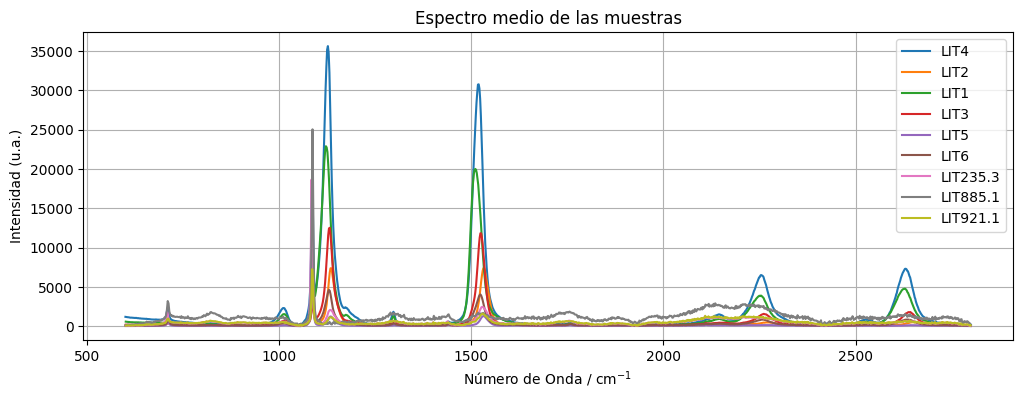

In [67]:
def avg_spectrum (data,
                  muestras , 
                   titulo = "Espectro medio de las muestras"):


  plt.figure(figsize=(12, 4))

  for i, muestra in enumerate(muestras):
    data_muestra = data[data.index.get_level_values('Muestra') == f'{muestra}']
    wavenumber = data_muestra.columns.get_level_values(0).astype(float)
    # Calculamos las intensidades medias para cada numero de onda
    mean_intensity = data_muestra.mean(axis=0)


    # Representa el espectro medio con el color correspondiente
    plt.plot(wavenumber, mean_intensity, label=f'{muestra}')

  # Etiquetas y título para el gráfico
  plt.xlabel("Número de Onda / cm$^{-1}$ ")
  plt.ylabel('Intensidad (u.a.)')
  plt.title(f'{titulo}')

  plt.legend()
  plt.grid(True)


  plt.show()

muestras_ordenadas = muestras = data.index.get_level_values('Muestra').unique().tolist()
avg_spectrum(data,muestras_ordenadas, titulo = "Espectro medio de las muestras")

In [70]:
data.to_csv('D:\OneDrive - UNICAN\Escritorio\Conchas\CSV_final\data_nanobase', index=True)